# Q学習を用いたオセロゲームAIの学習

- 概要<br />
今回、強化学習の習熟度を測る一環としてオセロにQ学習の適用を行った。<br />
学習の方針として、盤面を大きくしすぎると学習すべき状態数が膨大になるため、盤面を４×４や６×６とした。<br />
学習時は先手後手が互いに指す毎に一手先の報酬を用いて状態行動価値関数の更新を行う。<br />
評価時にはランダムとの対局を行い勝率を算出することで評価を行う。<br />


### - 学習手法<br />
 Q学習<br />
 ε-greedy<br />
 
### - 基本情報<br />
 盤面サイズ:4×4,6×6<br />
 エピソード数:1万局<br /> 
 報酬:勝利 +100 敗北 -100 引分け -10<br />

### - 学習パラメータ<br />
α(学習率)<br />γ(割引率)<br />ε(ランダム方策割合)<br />

### - 工夫点<br />
1. 引分け時に与える報酬を負にすることでなるべく勝ちを意識した学習ができると考えた。<br />
2. オセロなどのボードゲームの場合、盤面を回転してたとしても局面としては同一を捉えられると考え、状態行動価値関数の更新時に盤面を90度,180度,270度回転させ、学習データの複製を行った。<br />

適用したソースコードの場所に工夫点<番号>といったコメントを残す。<br />

### - 評価指標<br />
勝率(Q学習vsランダム)<br />
500エピソード間隔でランダムとの対局を行い勝率を算出<br />

### - 学習結果<br />
下記に各学習時のパラメータを記載し、以降の結果用セルの下部に結果に対する考察を明記する。<br />
結果1："othero(4×4) Q-learn α=0.1 γ=0.9 ε=0.01"<br />
結果2："othero(6×6) Q-learn α=0.1 γ=0.9 ε=0.01"<br />
結果3："othero(4×4) Q-learn α=0.1 γ=0.95 ε=0.01"<br />




In [344]:

import numpy as np
import random as rd
import copy

#rd.seed(0)

size = 6#8

class board:
    def __init__(self,size):
        self.size = size#盤面サイズ
        #self.ban = np.array([[0,0,0,0,0,0],
        #           [0,0,0,0,0,0],
        #           [0,0,1,-1,0,0],
        #           [0,0,-1,1,0,0],
        #           [0,0,0,0,0,0],
        #           [0,0,0,0,0,0]])# 0:空白 1:黒 -1:白
        self.ban = np.array([[0,0,0,0],
                   [0,1,-1,0],
                   [0,-1,1,0],
                   [0,0,0,0]])# 0:空白 1:黒 -1:白
        
        self.teban = 1 #先手:1 後手:-1
        

        
    def reverse(self,to):#置いた石に応じて石を裏返す処理
        tmp = copy.copy(self.ban)
        
        tmp[to]=self.teban#石を置く
        
        i = to[0]#行番号
        j = to[1]#列番号
        
        teki_flg = False#相手マスがあればTrue
        for k in range(i + 1):#上方向
            if (i-k) < 0 or tmp[i-k][j] == 0:#盤面外or空白があれば
                break
            if k == 1:
                if tmp[i-k][j] == self.teban:#自分の石があれば
                    break
            if tmp[i-k][j] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i-k][j] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i-k+l][j]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(self.size - i):#下方向
            if (i+k) >= self.size or tmp[i+k][j] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i+k][j] == self.teban:#自分の石があれば
                    break
            if tmp[i+k][j] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i+k][j] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i+k-l][j]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(j + 1):#左方向
            if (j-k) < 0 or tmp[i][j-k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i][j-k] == self.teban:#自分の石があれば
                    break
            if tmp[i][j-k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i][j-k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i][j-k+l]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(self.size - j):#右方向
            if (j+k) < 0 or tmp[i][j+k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i][j+k] == self.teban:#自分の石があれば
                    break
            if tmp[i][j+k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i][j+k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i][j+k-l]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(j + 1):#左上方向
            if (i-k) < 0 or (j-k) < 0 or tmp[i-k][j-k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i-k][j-k] == self.teban:#自分の石があれば
                    break
            if tmp[i-k][j-k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i-k][j-k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i-k+l][j-k+l]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(j + 1):#左下方向
            if (i+k) >= self.size or (j-k) < 0 or tmp[i+k][j-k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i+k][j-k] == self.teban:#自分の石があれば
                    break
            if tmp[i+k][j-k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i+k][j-k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i+k-l][j-k+l]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(self.size - j):#右上方向
            if (i-k) < 0 or (j+k) >= self.size or tmp[i-k][j+k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i-k][j+k] == self.teban:#自分の石があれば
                    break
            if tmp[i-k][j+k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i-k][j+k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i-k+l][j+k-l]=self.teban 
                break
        teki_flg = False#相手マスがあれば1
        for k in range(self.size - j):#右下方向
            if (i+k) >= self.size or (j+k) >= self.size or tmp[i+k][j+k] == 0:#盤面外or空白ならば
                break
            if k == 1:
                if tmp[i+k][j+k] == self.teban:#自分の石があれば
                    break
            if tmp[i+k][j+k] == (-1)*self.teban:#相手の石があれば
                teki_flg = True
            elif tmp[i+k][j+k] == self.teban and teki_flg:#自分の石かつteki_flg=Trueならば
                for l in range(k):
                    tmp[i+k-l][j+k-l]=self.teban 
                break
        return tmp
        
    def te(self,tmp_ban):#合法手リスト作成
        te = []
        for i in range(self.size):
            for j in range(self.size):
                if tmp_ban[i][j] == self.teban:
                    teki_flg = False#相手マスがあれば1
                    for k in range(i + 1):#上方向
                        if (i-k) < 0:
                            break
                        if tmp_ban[i-k][j] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i-k][j] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i-k][j] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i-k,j))
                                break
                    for k in range(self.size - i):#下方向
                        if (i+k) >= self.size:
                            break
                        if tmp_ban[i+k][j] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i+k][j] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i+k][j] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i+k,j))
                                break
                    for k in range(j + 1):#左方向
                        if (j-k) < 0:
                            break
                        if tmp_ban[i][j-k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i][j-k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i][j-k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            elif teki_flg == True:#teki_flg=Trueならば
                                te.append((i,j-k))
                                break
                    for k in range(self.size - j):#右方向
                        if (j+k) >= self.size:
                            break
                        if tmp_ban[i][j+k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i][j+k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i][j+k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            elif teki_flg == True:#teki_flg=Trueならば
                                te.append((i,j+k))
                                break
                    for k in range(j + 1):#左上方向
                        if (i-k) < 0 or (j-k) < 0:
                            break
                        if tmp_ban[i-k][j-k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i-k][j-k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i-k][j-k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i-k,j-k))
                                break
                    for k in range(j + 1):#左下方向
                        if (i+k) >= self.size or (j-k) < 0:
                            break
                        if tmp_ban[i+k][j-k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i+k][j-k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i+k][j-k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i+k,j-k))
                                break
                    for k in range(self.size - j):#右上方向
                        if (i-k) < 0 or (j+k) >= self.size:
                            break
                        if tmp_ban[i-k][j+k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i-k][j+k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i-k][j+k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i-k,j+k))
                                break
                    for k in range(self.size - j):#右下方向
                        if (i+k) >= self.size or (j+k) >= self.size:
                            break
                        if tmp_ban[i+k][j+k] == self.teban:#自分の石があれば
                            teki_flg = False
                        elif tmp_ban[i+k][j+k] == (-1)*self.teban:#相手の石があれば
                            teki_flg = True
                        elif tmp_ban[i+k][j+k] == 0:#空白ならば
                            if teki_flg == False:#teki_flg=Falseならば
                                break
                            if teki_flg == True:#teki_flg=Trueならば
                                te.append((i+k,j+k))
                                break
        return te
    
    def end_judgement(self,ban):#ゲーム終了判定
        zero_flg = False
        for i in range(self.size):
            for j in range(self.size):
                if ban[i][j] == 0:
                    zero_flg = True
        if zero_flg == True:
            return 0

        return 1

    def Print_Ban(self,tesu):#盤面表示
        tmp = np.where(self.ban == 1, "o",np.where(self.ban == -1, "x", " "))
        print(tesu+1,"手目")
        if self.teban == 1:
            print("手番:先手")
        else:
            print("手番:後手")
        print(tmp)

    def Winner_Judgement(self,ban):#駒カウント
        sente_ishi = 0
        gote_ishi = 0
        for i in range(self.size):
            for j in range(self.size):
                if ban[i][j] == 1:
                    sente_ishi += 1
                if ban[i][j] == -1:
                    gote_ishi += 1
        if sente_ishi > gote_ishi:
            return 1
        elif sente_ishi < gote_ishi:
            return -1
        else:
            return 0
        
    def put(self):#石を置く関数 返り値:-1⇒１手パス 返り値:1⇒石を置く
        goho_list = self.te(self.ban);#合法手リスト取得
        goho_list = list(set(goho_list))#合法手の重複除去
        if len(goho_list) == 0:#手番パス
            self.teban *= -1
            return -1
        to = rd.choice(goho_list)#ランダム選択
        self.ban[to]=self.teban#石を置く
        
        self.ban = self.reverse(to)#石をリバース
        
        self.teban *= -1
        return 1
    
    def Q_put(self,q):#Q学習による着手決定
        goho_list = self.te(self.ban);#合法手リスト取得
        goho_list = list(set(goho_list))#合法手の重複除去
        if len(goho_list) == 0:#手番パス
            self.teban *= -1
            return -1
        max_r = 0#報酬値保存用
        best_to = rd.choice(goho_list)#ランダム選択
        rand_num = rd.random()#乱数生成
        if rand_num > q.e:
            tmp = self.teban
            for to in goho_list:#状態価値関数を基に報酬最大になる手を選択
                self.teban = tmp
                q.set_q_value(self.ban,to)#関数セット
                next_ban = self.reverse(to)
                self.teban *= -1
                next_goho_list = self.te(next_ban);#合法手リスト取得

                max_next_r = 0
                for next_to in next_goho_list:#状態価値関数を基に報酬最大になる手を選択
                    self.teban = tmp
                    q.set_q_value(next_ban,next_to)#関数セット

                    next_r = q.get_q_value(next_ban,next_to)
                    if next_r > max_next_r:
                        max_next_r = next_r
                tmp_r = q.calc_reward(self.ban,to,max_next_r)*self.teban
                if tmp_r > max_r:
                    max_reward = tmp_r
                    best_to = to
            self.teban = tmp
            
        q.s_best_te = best_to
        q.rotate_q_func(q.s_t,q.s_best_te,self.size)#局面データ複製⇒状態行動価値関数格納 工夫点2
        self.ban = self.reverse(best_to)#石をリバース
        self.teban *= -1
        return 1

class q_learn:
    def __init__(self,alpha,gamma):
        self.alpha = alpha#学習率
        self.gamma = gamma#割引率
        self.e = 0.01#ランダム方策
        
        self.s_func = {}#状態行動価値関数 
        self.init_v = 0#初期報酬
        self.s_t = None#現時点の局面保存
        self.s_best_te = None#現時点からの最善手

        
    def set_q_value(self,x,te):#状態価値関数初期化
        x = (','.join(map(str,x))+','.join(map(str,te)))
        if self.s_func.get(x) is None:
            self.s_func[x] = self.init_v
    
    def get_q_value(self,x,te):#入力盤面の状態価値取得
        x = (','.join(map(str,x))+','.join(map(str,te)))
        if self.s_func.get(x) is None:
            self.s_func[x] = self.init_v
        return self.s_func.get(x)
    
    def last_set(self,x,te,r):
        x = (','.join(map(str,x))+','.join(map(str,te)))
        self.s_func[x] = r
    
    def calc_reward(self,ban,te,r):#現在の状態行動価値算出かつ状態行動価値関数の更新
        self.get_q_value(ban,te)
        q_t = ','.join(map(str,ban))+','.join(map(str,te))
        self.s_func[q_t] += self.alpha*(self.gamma * r - self.s_func[q_t])
        return self.s_func[q_t]
    
    def rotate_q_func(self,ban,te,size):#状態行動価値関数の複製 工夫点2

        deg = np.deg2rad(90)#90度ラジアン算出
        cos = np.cos(deg)
        sin = np.sin(deg)
        rot = np.array([[cos,(-1)*sin],
                        [sin,cos]])#回転行列

        r = self.get_q_value(ban,te)

        te_arr = np.array(te)
        offset = size/2 - 0.5 #原点移動用オフセット

        for _ in range(3):
            te_arr = te_arr - offset #平行移動
            ban = np.rot90(ban)#盤面を90度回転
            te_arr = np.dot(rot,te_arr) + offset#平行移動
            te_arr2 = [int(np.round(i)) for i in te_arr]
            self.last_set(ban,te_arr2,r)#状態行動価値関数格納
        
game_num = 10000

sente_win_num = 0#先手勝利数カウント
gote_win_num = 0#後手勝利数カウント
draw_num = 0#引き分け数カウント

step_num = []#ステップ数格納
total_win_ratio = []#学習ステップ毎の勝率格納

#学習開始
q = q_learn(0.1,0.9)

for g in range(game_num):
    ban = board(size);
    for i in range(size*size):
        q.s_t = ban.ban
        put_flg = ban.Q_put(q)
        if put_flg == 1:#局面を保存
            if ban.end_judgement(ban.ban) == 1:#終了判定
                break
    win_label = ban.Winner_Judgement(ban.ban)
    if win_label == 1:
        q.last_set(q.s_t, q.s_best_te, 100)
        sente_win_num += 1
        #print("先手の勝ち")
    elif win_label == -1:
        q.last_set(q.s_t, q.s_best_te, -100)
        gote_win_num += 1
        #print("後手の勝ち")
    else:
        draw_num += 1
        q.last_set(q.s_t, q.s_best_te, -10)#工夫点1
        #print("引き分け")
    q.rotate_q_func(q.s_t,q.s_best_te,size)#最終局面データ複製⇒状態行動価値関数格納
    
    if g != 0 and g % 500 == 0:
        print("learn step",g,"/",game_num)
        
        
        #モンテカルロ法vsランダム対戦
        #rd.seed(0)
        eval_num = 100

        sente_win_num = 0#先手勝利数カウント
        gote_win_num = 0#後手勝利数カウント
        draw_num = 0#引き分け数カウント

        for e in range(eval_num):
            ban2 = board(size);
            for j in range(size*size):
                #ban2.Print_Ban(j)
                if ban2.teban == 1:#先手ならモンテカルロ法による着手
                    goho_list = ban2.te(ban2.ban);#合法手リスト取得
                    goho_list = list(set(goho_list))#合法手の重複除去
                    if len(goho_list) == 0:#手番パス
                        ban2.teban *= -1
                    else:
                        max_r = 0#報酬値保存用
                        best_to = rd.choice(goho_list)#ランダム選択
                        for to in goho_list:#状態価値関数を基に報酬最大になる手を選択
                            tmp_r = q.get_q_value(ban2.ban,to)*ban2.teban
                            if tmp_r > max_r:
                                max_r = tmp_r
                                best_to = to

                        ban2.ban = ban2.reverse(best_to)#石をリバース
                        ban2.teban *= -1
                elif ban2.teban == -1:#後手ならランダムによる着手
                    ban2.put()

                if ban2.end_judgement(ban2.ban) == 1:
                    break
            win_label = ban2.Winner_Judgement(ban2.ban)
            if win_label == 1:
                sente_win_num += 1
            elif win_label == -1:
                gote_win_num += 1
            else:
                draw_num += 1

        n = (sente_win_num+gote_win_num)
        sente_win = 0
        gote_win = 0
        if n != 0:
            sente_win = sente_win_num/(sente_win_num+gote_win_num)
            gote_win = gote_win_num/(sente_win_num+gote_win_num)
            print("先手勝率:",sente_win)
            print("後手勝率:",gote_win)

        step_num.append(g)
        total_win_ratio.append(sente_win)


learn step 500 / 10000
先手勝率: 0.5052631578947369
後手勝率: 0.49473684210526314
learn step 1000 / 10000
先手勝率: 0.46808510638297873
後手勝率: 0.5319148936170213
learn step 1500 / 10000
先手勝率: 0.5053763440860215
後手勝率: 0.4946236559139785
learn step 2000 / 10000
先手勝率: 0.41304347826086957
後手勝率: 0.5869565217391305
learn step 2500 / 10000
先手勝率: 0.449438202247191
後手勝率: 0.550561797752809
learn step 3000 / 10000
先手勝率: 0.46464646464646464
後手勝率: 0.5353535353535354
learn step 3500 / 10000
先手勝率: 0.46875
後手勝率: 0.53125
learn step 4000 / 10000
先手勝率: 0.46875
後手勝率: 0.53125
learn step 4500 / 10000
先手勝率: 0.4631578947368421
後手勝率: 0.5368421052631579
learn step 5000 / 10000
先手勝率: 0.3655913978494624
後手勝率: 0.6344086021505376
learn step 5500 / 10000
先手勝率: 0.4838709677419355
後手勝率: 0.5161290322580645
learn step 6000 / 10000
先手勝率: 0.48936170212765956
後手勝率: 0.5106382978723404
learn step 6500 / 10000
先手勝率: 0.4574468085106383
後手勝率: 0.5425531914893617
learn step 7000 / 10000
先手勝率: 0.45652173913043476
後手勝率: 0.5434782608695652
learn

## 結果1

Text(0, 0.5, 'win_ratio')

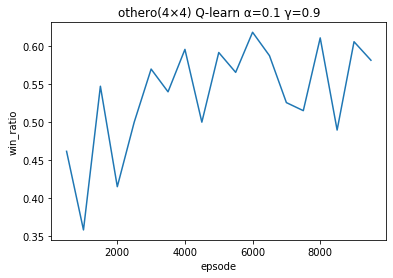

In [343]:
import matplotlib.pyplot as plt
#勝率推移グラフ
plt.plot(step_num,total_win_ratio)
plt.title("othero(4×4) Q-learn α=0.1 γ=0.9")
plt.xlabel("epsode")
plt.ylabel("win_ratio")

### 結果1の考察<br />
エピソード数が増加するにつれ勝率が増加していく傾向となり、ランダム相手に勝ち越すことができた。<br />
その中でも勝率が安定しないのは学習量が少ないか評価時の対局数が100局と少ないため評価方法自体の問題ではないかと推測される。<br />

## 結果2

Text(0, 0.5, 'win_ratio')

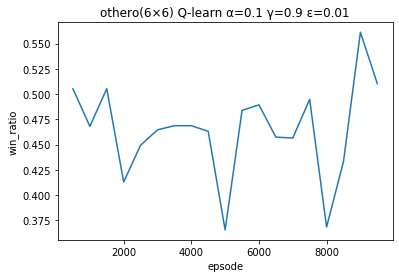

In [355]:
import matplotlib.pyplot as plt
#勝率推移グラフ
plt.plot(step_num,total_win_ratio)
plt.title("othero(6×6) Q-learn α=0.1 γ=0.9 ε=0.01")
plt.xlabel("epsode")
plt.ylabel("win_ratio")

### 結果2の考察<br />
1万エピソードに到達しても勝率が安定しない結果となった。<br />
これは盤面サイズ6×6と大きいため、状態行動価値関数の更新の網羅率が低いことが起因したといえる。<br />